# Twitter Sentiment Analysis with Bert
In this notebook we show how to finetune BERT to our annotated dataset to do sentiment classification on twitter.





In [ ]:
!pip install -qq transformers

In [ ]:
 

import numpy as np 
import pandas as pd 

import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch

import os

import matplotlib.pyplot as plt

import seaborn as sns

from math import sqrt 
from scipy.stats import norm
from random import choices

from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader


import random

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


## Set up Drive

In [ ]:
ls drive/MyDrive/

ls: cannot access 'drive/MyDrive/': No such file or directory


In [ ]:
#drive.flush_and_unmount()


In [ ]:
from google.colab import drive 
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
cd "drive/MyDrive/ANLP/NLP Sentiment Analysis Project/"

[Errno 2] No such file or directory: 'drive/MyDrive/ANLP/NLP Sentiment Analysis Project/'
/content/drive/.shortcut-targets-by-id/1EEAMp2gMUPTvnKYcU2nsfd_CFpRwX-Fh/NLP Sentiment Analysis Project


## Sentiment140 Data

In our first run of the sentiment classifier model we use the Sentiment140 dataset.  This consists of 1.6 million tweets, half labeled positive and half labeled negative.  To use, set the SentimentClassifier parameter to 2 for 2 classes.

In [ ]:
t140 = pd.read_csv('sentiment140_data/training.1600000.processed.noemoticon.csv',
                   sep=',',
                   header=None,
                   encoding='latin')

label_text = t140[[0, 5]]

label_text.columns = ['label', 'text']

label_text.head()

,label,text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."


## Annotated Data

In our second run we use data that was annotated personally by ourselves with positive, neutral and negative labels and see if there is an improvement.  To use, set the SentimentClassifier parameter to 3 for 3 classes.

In [ ]:
###alternative data

t140 = pd.read_csv('coffee_data/coffee_tweets_979.csv',
                   sep=',',
                   header=[0],
                   encoding='latin')

label_text = t140[['tweet','sentiment']]

# Convert labels to range 0-1                                        
#label_text[0] = label_text[0].apply(lambda x: 0 if x == 0 else 1)

# Assign proper column names to labels
label_text.columns = ['text', 'label']

label_text['label'] = label_text['label'] + 1

# Assign proper column names to labels

label_text['label'] = label_text['label'].apply(lambda x: int(x))
label_text.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,text,label
0,$300 for a molded plastic coffee table is some...,1
1,#PUROASTCoffee at #MENOPE \nvia @PUROASTCoffee...,1
2,@tptcourses @Roost_Coffee Following. Thank you...,2
3,Theyâre steadily falling out of the vent and...,1
4,@McDonaldsCanada I'm handing out as many hot m...,2


We then filter out hashtags and emojis to simplify the model and ensure the model won't overfit on them

In [ ]:
import re

hashtags = re.compile(r"^#\S+|\s#\S+")
mentions = re.compile(r"^@\S+|\s@\S+")
urls = re.compile(r"https?://\S+")

def process_text(text):
  text = hashtags.sub(' hashtag', text)
  text = mentions.sub(' entity', text)
  return text.strip().lower()
  
def match_expr(pattern, string):
  return not pattern.search(string) == None

def get_data_wo_urls(dataset):
    link_with_urls = dataset.text.apply(lambda x: match_expr(urls, x))
    return dataset[[not e for e in link_with_urls]]

In [ ]:
label_text.text = label_text.text.apply(process_text)

/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [ ]:
random.seed(42)

from sklearn.model_selection import train_test_split
TRAIN_SIZE = 0.75
VAL_SIZE = 0.125
dataset_count = len(label_text)

df_train_val, df_test = train_test_split(label_text, test_size=1-TRAIN_SIZE-VAL_SIZE, random_state=42)
df_train, df_val = train_test_split(df_train_val, test_size=VAL_SIZE / (VAL_SIZE + TRAIN_SIZE), random_state=42)

print("TRAIN size:", len(df_train))
print("VAL size:", len(df_val))
print("TEST size:", len(df_test))

TRAIN size: 733
VAL size: 123
TEST size: 123


In [ ]:
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [ ]:
#We shrink the size of the sentiment140 dataset to much smaller than 1.6 million tweets, or else it takes forever to train the model

df_train = df_train[:20000]
df_val = df_val[:4000]
df_test = df_test[:4000]

In [ ]:
df_train.sample(frac=1.0).reset_index(drop=True).to_csv('sentiment140_data/train.tsv', sep='\t', index=None, header=None)
df_val.to_csv('sentiment140_data/dev.tsv', sep='\t', index=None, header=None)
df_test.to_csv('sentiment140_data/test.tsv', sep='\t', index=None, header=None)
#! cd dataset && ls

## Data Prep for BERT


In [ ]:
# Choose BERT model to use (lower-cased words model)

PRE_TRAINED_MODEL_NAME = 'bert-base-uncased'

tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)


In [ ]:
sample_txt = df_train.loc[0]['text']

sample_txt

'entity entity entity entity entity entity yup, entity is my busâ\x80¦ https://t.co/rs2uzt6mug'

In [ ]:
#set up encoder for tweets

encoding = tokenizer.encode_plus(
  sample_txt,
  max_length=32,
  add_special_tokens=True, # Add '[CLS]' and '[SEP]'
  return_token_type_ids=False,
  pad_to_max_length=True,
  return_attention_mask=True,
  return_tensors='pt',  # Return PyTorch tensors
)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2269: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [ ]:
tokens = tokenizer.tokenize(sample_txt)
token_ids = tokenizer.convert_tokens_to_ids(tokens)
print(f' Sentence: {sample_txt}')
print(f'   Tokens: {tokens}')
print(f'Token IDs: {token_ids}')

 Sentence: entity entity entity entity entity entity yup, entity is my busâ¦ https://t.co/rs2uzt6mug
   Tokens: ['entity', 'entity', 'entity', 'entity', 'entity', 'entity', 'yu', '##p', ',', 'entity', 'is', 'my', 'bus', '##a', '##¦', 'https', ':', '/', '/', 't', '.', 'co', '/', 'rs', '##2', '##uz', '##t', '##6', '##mu', '##g']
Token IDs: [9178, 9178, 9178, 9178, 9178, 9178, 9805, 2361, 1010, 9178, 2003, 2026, 3902, 2050, 29649, 16770, 1024, 1013, 1013, 1056, 1012, 2522, 1013, 12667, 2475, 17040, 2102, 2575, 12274, 2290]


In [ ]:
#example of tokenized, padded entries

tokenizer.convert_ids_to_tokens(encoding['input_ids'][0])

['[CLS]',
 'entity',
 'entity',
 'entity',
 'entity',
 'entity',
 'entity',
 'yu',
 '##p',
 ',',
 'entity',
 'is',
 'my',
 'bus',
 '##a',
 '##¦',
 'https',
 ':',
 '/',
 '/',
 't',
 '.',
 'co',
 '/',
 'rs',
 '##2',
 '##uz',
 '##t',
 '##6',
 '##mu',
 '##g',
 '[SEP]']

In [ ]:
token_lens = []
for txt in df_train['text']:
  tokens = tokenizer.encode(txt, max_length=512)
  token_lens.append(len(tokens))

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


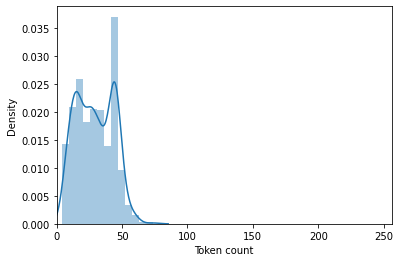

In [ ]:
# Plot of token count for given tweets in training data

sns.distplot(token_lens)
plt.xlim([0, 256]);
plt.xlabel('Token count');

In [ ]:
#set max number of tokens in tweets
MAX_LEN = 32

In [ ]:
# Create a PyTorch dataset

class TweetDataset(Dataset):
  def __init__(self, tweets, targets, tokenizer, max_len):
    self.tweets = tweets
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_len
  def __len__(self):
    return len(self.tweets)
  def __getitem__(self, item):
    tweet = str(self.tweets[item])
    target = self.targets[item]
    encoding = self.tokenizer.encode_plus(
      tweet,
      add_special_tokens=True,
      max_length=self.max_len,
      return_token_type_ids=False,
      pad_to_max_length=True,
      return_attention_mask=True,
      return_tensors='pt',
    )
    return {
      'tweet_text': tweet,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'targets': torch.tensor(target, dtype=torch.long)
    }

In [ ]:
def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = TweetDataset(
    tweets=df['text'].to_numpy(),
    targets=df['label'].to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len
  )
  return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=4
  )

BATCH_SIZE = 16


In [ ]:
train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
data = next(iter(train_data_loader))
data.keys()


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2269: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/py

dict_keys(['tweet_text', 'input_ids', 'attention_mask', 'targets'])

In [ ]:
print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['targets'].shape)

torch.Size([16, 32])
torch.Size([16, 32])
torch.Size([16])


## Training The BERT Model with PyTorch

In [ ]:
EPOCHS = 50

In [ ]:
#Load the BERT model to use

bert_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
last_hidden_state, pooled_output = bert_model(
  input_ids=encoding['input_ids'],
  attention_mask=encoding['attention_mask']
)

In [ ]:
b = bert_model(
  input_ids=encoding['input_ids'],
  attention_mask=encoding['attention_mask']
)

pooler_output = b['pooler_output']

In [ ]:
#pooler_output

In [ ]:
class SentimentClassifier(nn.Module):
  def __init__(self, n_classes):
    super(SentimentClassifier, self).__init__()
    self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
    self.drop = nn.Dropout(p=0.3)
    self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
  def forward(self, input_ids, attention_mask):
    #_, pooled_output = self.bert(
    #  input_ids=input_ids,
    #  attention_mask=attention_mask
    #)
    pooled_output = self.bert(
      input_ids=input_ids,
      attention_mask=attention_mask
      )['pooler_output']
    output = self.drop(pooled_output)
    return self.out(output)

In [ ]:
model = SentimentClassifier(3) #2 classes, may need to change to three if we do good/neutral/bad


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
CUDA_LAUNCH_BLOCKING=1

In [ ]:
model = model.to(device)

In [ ]:
#model.load_state_dict(torch.load('best_model_state.bin'))


### Training

In [ ]:
EPOCHS = 10
optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)
loss_fn = nn.CrossEntropyLoss().to(device)

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


In [ ]:
def train_epoch(
  model,
  data_loader,
  loss_fn,
  optimizer,
  device,
  scheduler,
  n_examples
):
  model = model.train()
  losses = []
  correct_predictions = 0
  for d in data_loader:
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    targets = d["targets"].to(device)
    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask
    )
    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, targets)
    correct_predictions += torch.sum(preds == targets)
    losses.append(loss.item())
    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()
  return correct_predictions.double() / n_examples, np.mean(losses)

In [ ]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()
  losses = []
  correct_predictions = 0
  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)
      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)
      loss = loss_fn(outputs, targets)
      correct_predictions += torch.sum(preds == targets)
      losses.append(loss.item())
  return correct_predictions.double() / n_examples, np.mean(losses)

In [ ]:
%%time
history = defaultdict(list)
best_accuracy = 0
for epoch in range(EPOCHS):
  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)
  train_acc, train_loss = train_epoch(
    model,
    train_data_loader,
    loss_fn,
    optimizer,
    device,
    scheduler,
    len(df_train)
  )
  print(f'Train loss {train_loss} accuracy {train_acc}')
  val_acc, val_loss = eval_model(
    model,
    val_data_loader,
    loss_fn,
    device,
    len(df_val)
  )
  print(f'Val   loss {val_loss} accuracy {val_acc}')
  print()
  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)
  if val_acc > best_accuracy:
    torch.save(model.state_dict(), 'best_model_state.bin')
    best_accuracy = val_acc

Epoch 1/10
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2269: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/py

Train loss 0.8934201131696287 accuracy 0.592087312414734


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2269: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2269: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Val   loss 0.7425379157066345 accuracy 0.6829268292682927

Epoch 2/10
----------


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2269: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2269: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Train loss 0.615995493919953 accuracy 0.7435197817189632


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2269: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2269: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Val   loss 0.8356358371675014 accuracy 0.7073170731707317

Epoch 3/10
----------


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2269: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2269: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Train loss 0.3134113621047657 accuracy 0.8949522510231923


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2269: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2269: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Val   loss 1.3451459631323814 accuracy 0.6829268292682927

Epoch 4/10
----------


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2269: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2269: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Train loss 0.13748874704596464 accuracy 0.9536152796725784


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2269: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2269: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Val   loss 1.1975797936320305 accuracy 0.7398373983739838

Epoch 5/10
----------


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2269: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2269: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Train loss 0.061696715192342905 accuracy 0.9822646657571623


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2269: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2269: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Val   loss 1.4216466769576073 accuracy 0.7073170731707317

Epoch 6/10
----------


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2269: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2269: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Train loss 0.017806178515615022 accuracy 0.9945429740791268


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2269: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2269: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Val   loss 1.5921898633241653 accuracy 0.7073170731707317

Epoch 7/10
----------


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2269: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2269: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Train loss 0.01277807295707095 accuracy 0.9959072305593452


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2269: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2269: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Val   loss 1.8014470040798187 accuracy 0.6991869918699187

Epoch 8/10
----------


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2269: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2269: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Train loss 0.009300407677706655 accuracy 0.9972714870395635


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2269: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2269: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Val   loss 1.7225162833929062 accuracy 0.7317073170731707

Epoch 9/10
----------


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2269: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2269: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Train loss 0.0019163655258877122 accuracy 1.0


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2269: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2269: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Val   loss 1.7412985861301422 accuracy 0.7317073170731707

Epoch 10/10
----------


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2269: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2269: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Train loss 0.0009762996784917524 accuracy 1.0


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2269: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2269: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Val   loss 1.761364795267582 accuracy 0.7154471544715447

CPU times: user 46min 10s, sys: 5min 31s, total: 51min 42s
Wall time: 52min 1s


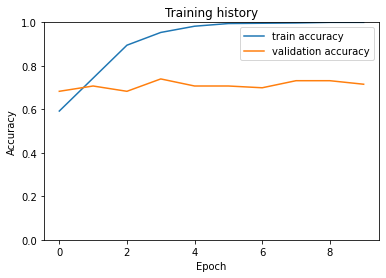

In [ ]:
plt.plot([x.item() for x in history['train_acc']], label='train accuracy')
plt.plot([x.item() for x in history['val_acc']], label='validation accuracy')
plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

## Evaluate Model

In [214]:
model.load_state_dict(torch.load('best_model_state.bin'))


<All keys matched successfully>

In [215]:
test_acc, _ = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(df_test)
)
test_acc.item()

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2269: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/py

0.6991869918699187

In [216]:
def get_predictions(model, data_loader):
  model = model.eval()
  review_texts = []
  predictions = []
  prediction_probs = []
  real_values = []
  with torch.no_grad():
    for d in data_loader:
      texts = d["tweet_text"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)
      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)
      review_texts.extend(texts)
      predictions.extend(preds)
      prediction_probs.extend(outputs)
      real_values.extend(targets)
  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  return review_texts, predictions, prediction_probs, real_values

In [217]:
y_tweet_texts, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  test_data_loader
)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2269: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/py

In [218]:
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.46      0.50      0.48        12
           1       0.79      0.78      0.79        69
           2       0.62      0.62      0.62        42

    accuracy                           0.70       123
   macro avg       0.62      0.63      0.63       123
weighted avg       0.70      0.70      0.70       123



In [219]:
label_text['label'].value_counts()

1    558
2    326
0     95
Name: label, dtype: int64

In [222]:
baseline_accuracy = 558/(558+326+95)

.71 - baseline_accuracy

0.14003064351378958

## Bootstrap Confidence Intervals

In [223]:
def accuracy(truth, predictions):
    correct=0.
    for idx in range(len(truth)):
        g=truth[idx]
        p=predictions[idx]
        if g == p:
            correct+=1
    return correct/len(truth)

In [224]:
def F1(truth, predictions):
    correct=0.
    trials=0.
    trues=0.
    for idx in range(len(truth)):
        g=truth[idx]
        p=predictions[idx]
        if g == p and g == 1:
            correct+=1
        if g == 1:
            trues+=1
        if p == 1:
            trials+=1
            
    precision=correct/trials if trials > 0 else 0
    recall=correct/trues if trues > 0 else 0
    f=(2*precision*recall)/(precision+recall) if (precision+recall) > 0 else 0
    return f

In [225]:
def bootstrap(gold, predictions, metric, B=10000, confidence_level=0.95):
    critical_value=(1-confidence_level)/2
    lower_sig=100*critical_value
    upper_sig=100*(1-critical_value)
    data=[]
    for g, p in zip(gold, predictions):
        data.append([g,p])

    accuracies=[]
    
    for b in range(B):
        choice=choices(data, k=len(data))
        choice=np.array(choice)
        accuracy=metric(choice[:,0], choice[:,1])
        
        accuracies.append(accuracy)
    
    percentiles=np.percentile(accuracies, [lower_sig, 50, upper_sig])
    
    lower=percentiles[0]
    median=percentiles[1]
    upper=percentiles[2]
    
    return lower, median, upper


In [226]:
lower, median, upper = bootstrap(y_test, y_pred, accuracy)

In [227]:
print('Accuracy confidence intervals.  Lower: ' + str(lower) + ', Middle: ' + str(median) + ', Upper: ' + str(upper))

Accuracy confidence intervals.  Lower: 0.6178861788617886, Middle: 0.6991869918699187, Upper: 0.7804878048780488


In [228]:
f1_lower, f1_median, f1_upper = bootstrap(y_test, y_pred, F1)

In [229]:
print('F1 confidence intervals.  Lower: ' + str(f1_lower) + ', Middle: ' + str(f1_median) + ', Upper: ' + str(f1_upper))

F1 confidence intervals.  Lower: 0.7058823529411764, Middle: 0.7891156462585034, Upper: 0.8592621527777777


## Predicting Sentiment on Tweets from the Twitter API

Now that we've built our sentiment classifier engine and have verified that it performs well on new data, we can use the engine to classify new tweets and run analytics and graphing on the data.

In [230]:
def get_prediction(tweet):
  
  #step from the very top of the notebook
  tweet = process_text(tweet)

  encoded_tweet = tokenizer.encode_plus(
    tweet,
    max_length=MAX_LEN,
    add_special_tokens=True,
    return_token_type_ids=False,
    pad_to_max_length=True,
    return_attention_mask=True,
    return_tensors='pt',
  )

  input_ids = encoded_tweet['input_ids'].to(device)
  attention_mask = encoded_tweet['attention_mask'].to(device)
  output = model(input_ids, attention_mask)
  _, prediction = torch.max(output, dim=1)

  return(prediction[0].item())

## Graphs

In [231]:
df1 = pd.read_csv('food_tweets_agriculture.csv')

In [232]:
df1['predictions'] = df1['tweet'].apply(lambda x: get_prediction(x))

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2269: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [233]:
df1_grouped = df1.groupby('word').sum()['predictions']

In [234]:
df1_grouped = df1_grouped.sort_values()

In [235]:
df1_grouped = (df1_grouped/200) * 100

In [236]:
df2 = pd.read_csv('food_tweets_diverse.csv')

In [237]:
df2['predictions'] = df2['tweet'].apply(lambda x: get_prediction(x))

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2269: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [238]:
df2_grouped = df2.groupby('word').sum()['predictions']

In [183]:
df2_grouped = df2_grouped.sort_values()

In [184]:
df2_grouped = (df2_grouped/200) * 100

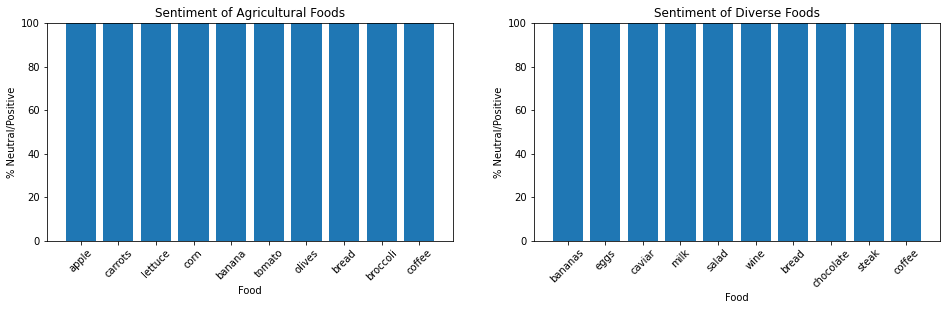

In [185]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))

ax1.set_xticklabels(df1_grouped.index, rotation=45)
ax2.set_xticklabels(df2_grouped.index, rotation=45)


ax1.bar(df1_grouped.index, df1_grouped)
ax2.bar(df2_grouped.index, df2_grouped)

ax1.set_title('Sentiment of Agricultural Foods')
ax2.set_title('Sentiment of Diverse Foods')

ax1.set_xlabel('Food')
ax2.set_xlabel('Food')

ax1.set_ylabel('% Neutral/Positive')
ax2.set_ylabel('% Neutral/Positive')


ax1.set_ylim([0, 100])
ax2.set_ylim([0, 100])


plt.show()

## Classify ~50,000 Coffee Tweets Over 9 Years and Correlate with Price Data

In [186]:
df = pd.read_json('coffee_post_pandemic_tweets.json', lines=True)

In [187]:
df = df[~df['content'].str.contains('@')].reset_index(drop=True)

In [188]:
df = df[['date','content']]

In [189]:
df['date'] = df['date'].apply(lambda x: x.strftime('%Y-%m-%d'))

In [190]:
df = df.sort_values('date')

In [191]:
#df['predictions'] = df['content'].apply(lambda x: get_prediction(x))

In [192]:
#df.to_csv('coffee_post_pandemic_tweets_preds.csv', index=False)

In [193]:
df = pd.read_csv('coffee_post_pandemic_tweets_preds.csv')

In [ ]:
df_positive_timeseries = df[df['predictions'] == 2].groupby('date').count()['predictions'] / df.groupby('date').count()['predictions']
df_neutral_timeseries = df[df['predictions'] == 1].groupby('date').count()['predictions'] / df.groupby('date').count()['predictions']
df_negative_timeseries = df[df['predictions'] == 0].groupby('date').count()['predictions'] / df.groupby('date').count()['predictions']




In [195]:
df_positive_timeseries = df_positive_timeseries.dropna()
df_neutral_timeseries = df_neutral_timeseries.dropna()
df_negative_timeseries = df_negative_timeseries.dropna()


In [196]:
#https://www.macrotrends.net/2535/coffee-prices-historical-chart-data

coffee_prices = pd.read_csv('coffee_prices.csv')

In [197]:
coffee_prices.columns = ['date','price']

In [198]:
from datetime import datetime


In [199]:
coffee_prices['date'] = coffee_prices['date'].apply(lambda x: datetime.strptime(x, '%m/%d/%y').strftime('%Y-%m-%d'))

In [200]:
coffee_prices_matched = coffee_prices[coffee_prices['date'].isin(list(df_positive_timeseries.index))]

In [201]:
coffee_prices = coffee_prices.reset_index(drop=True)

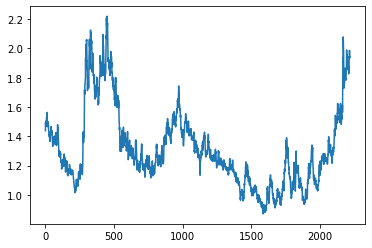

In [202]:
plt.plot(coffee_prices['price'])

In [203]:
matched_indices = [int(np.round(x)) for x in np.linspace(0, len(coffee_prices)-1, num=36)]

In [204]:
len(matched_indices)

36

In [205]:
coffee_prices_matched = coffee_prices.iloc[matched_indices].reset_index(drop=True)

In [206]:
len(coffee_prices_matched)

36

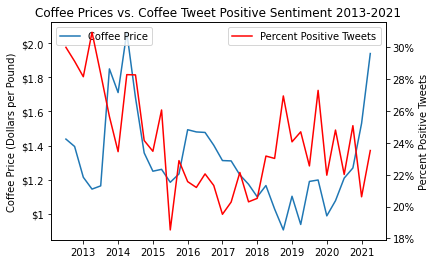

In [207]:
fig, ax1 = plt.subplots()
#fig.tight_layout(pad=20)

plt.title('Coffee Prices vs. Coffee Tweet Positive Sentiment 2013-2021')

ax1.plot(coffee_prices_matched['price'], label='Coffee Price')
ax1.set_ylabel('Coffee Price (Dollars per Pound)')
ax1.set_yticklabels(['$.8','$1','$1.2','$1.4','$1.6','$1.8','$2.0'])

ax2 = ax1.twinx()
ax2.plot(df_positive_timeseries, color='red', label='Percent Positive Tweets')
ax2.set_ylabel('Percent Positive Tweets')
ax2.set_yticklabels(['16%','18%','20%','22%','24%','26%','28%','30%'])


ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

#plt.legend()

plt.xticks([2,6,10,14,18,22,26,30,34], labels=['2013','2014','2015','2016','2017','2018','2019','2020','2021'])

plt.show()

In [ ]:
fig, ax1 = plt.subplots()
#fig.tight_layout(pad=20)

plt.title('Coffee Prices vs. Coffee Tweet Positive Sentiment (Points are 3-Month Intervals) 2013-2021')

#ax1.plot(coffee_prices_matched['price'], label='Coffee Price')
#ax1.set_ylabel('Coffee Price (Dollars per Pound)')
#ax1.set_yticklabels(['$.8','$1','$1.2','$1.4','$1.6','$1.8','$2.0'])

#ax2 = ax1.twinx()
#ax2.plot(df_positive_timeseries, color='red', label='Percent Positive Tweets')
#ax2.set_ylabel('Percent Positive Tweets')
#ax2.set_yticklabels(['16%','18%','20%','22%','24%','26%','28%','30%'])

plt.scatter(coffee_prices_matched['price'], df_positive_timeseries)

plt.xlabel('Coffee Price (Dollars per Pound)')
plt.ylabel('Percent Positive Tweets')

#ax1.legend(loc='upper left')
#ax2.legend(loc='upper right')

#plt.legend()

#plt.xticks([2,6,10,14,18,22,26,30,34], labels=['2013','2014','2015','2016','2017','2018','2019','2020','2021'])

plt.show()

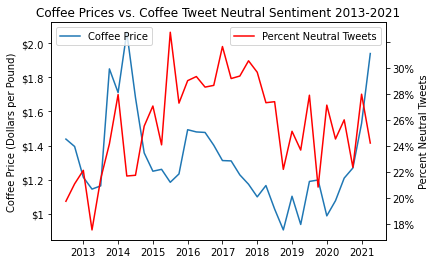

In [209]:
fig, ax1 = plt.subplots()
#fig.tight_layout(pad=20)

plt.title('Coffee Prices vs. Coffee Tweet Neutral Sentiment 2013-2021')

ax1.plot(coffee_prices_matched['price'], label='Coffee Price')
ax1.set_ylabel('Coffee Price (Dollars per Pound)')
ax1.set_yticklabels(['$.8','$1','$1.2','$1.4','$1.6','$1.8','$2.0'])

ax2 = ax1.twinx()
ax2.plot(df_neutral_timeseries, color='red', label='Percent Neutral Tweets')
ax2.set_ylabel('Percent Neutral Tweets')
ax2.set_yticklabels(['16%','18%','20%','22%','24%','26%','28%','30%'])


ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

#plt.legend()

plt.xticks([2,6,10,14,18,22,26,30,34], labels=['2013','2014','2015','2016','2017','2018','2019','2020','2021'])

plt.show()

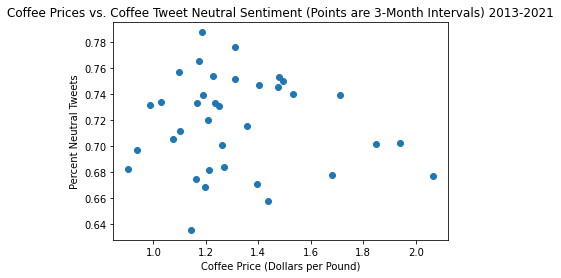

In [210]:
fig, ax1 = plt.subplots()
#fig.tight_layout(pad=20)

plt.title('Coffee Prices vs. Coffee Tweet Neutral Sentiment (Points are 3-Month Intervals) 2013-2021')

#ax1.plot(coffee_prices_matched['price'], label='Coffee Price')
#ax1.set_ylabel('Coffee Price (Dollars per Pound)')
#ax1.set_yticklabels(['$.8','$1','$1.2','$1.4','$1.6','$1.8','$2.0'])

#ax2 = ax1.twinx()
#ax2.plot(df_positive_timeseries, color='red', label='Percent Positive Tweets')
#ax2.set_ylabel('Percent Positive Tweets')
#ax2.set_yticklabels(['16%','18%','20%','22%','24%','26%','28%','30%'])

plt.scatter(coffee_prices_matched['price'], df_neutral_timeseries)

plt.xlabel('Coffee Price (Dollars per Pound)')
plt.ylabel('Percent Neutral Tweets')

#ax1.legend(loc='upper left')
#ax2.legend(loc='upper right')

#plt.legend()

#plt.xticks([2,6,10,14,18,22,26,30,34], labels=['2013','2014','2015','2016','2017','2018','2019','2020','2021'])

plt.show()

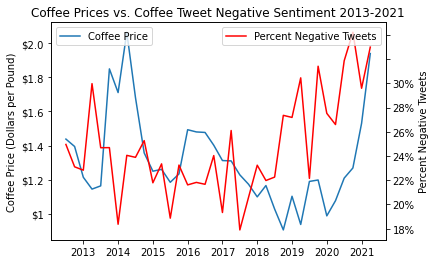

In [211]:
fig, ax1 = plt.subplots()
#fig.tight_layout(pad=20)

plt.title('Coffee Prices vs. Coffee Tweet Negative Sentiment 2013-2021')

ax1.plot(coffee_prices_matched['price'], label='Coffee Price')
ax1.set_ylabel('Coffee Price (Dollars per Pound)')
ax1.set_yticklabels(['$.8','$1','$1.2','$1.4','$1.6','$1.8','$2.0'])

ax2 = ax1.twinx()
ax2.plot(df_negative_timeseries, color='red', label='Percent Negative Tweets')
ax2.set_ylabel('Percent Negative Tweets')
ax2.set_yticklabels(['16%','18%','20%','22%','24%','26%','28%','30%'])


ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

#plt.legend()

plt.xticks([2,6,10,14,18,22,26,30,34], labels=['2013','2014','2015','2016','2017','2018','2019','2020','2021'])

plt.show()

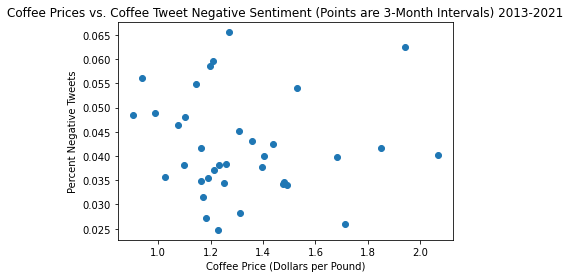

In [212]:
fig, ax1 = plt.subplots()
#fig.tight_layout(pad=20)

plt.title('Coffee Prices vs. Coffee Tweet Negative Sentiment (Points are 3-Month Intervals) 2013-2021')

#ax1.plot(coffee_prices_matched['price'], label='Coffee Price')
#ax1.set_ylabel('Coffee Price (Dollars per Pound)')
#ax1.set_yticklabels(['$.8','$1','$1.2','$1.4','$1.6','$1.8','$2.0'])

#ax2 = ax1.twinx()
#ax2.plot(df_positive_timeseries, color='red', label='Percent Positive Tweets')
#ax2.set_ylabel('Percent Positive Tweets')
#ax2.set_yticklabels(['16%','18%','20%','22%','24%','26%','28%','30%'])

plt.scatter(coffee_prices_matched['price'], df_negative_timeseries)

plt.xlabel('Coffee Price (Dollars per Pound)')
plt.ylabel('Percent Negative Tweets')

#ax1.legend(loc='upper left')
#ax2.legend(loc='upper right')

#plt.legend()

#plt.xticks([2,6,10,14,18,22,26,30,34], labels=['2013','2014','2015','2016','2017','2018','2019','2020','2021'])

plt.show()

# Correlation Coefficients for positive, neutral and negative time series

In [213]:
from scipy import stats

#https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.stats.pearsonr.html

# Y and Z are numpy arrays or lists of variables 
print(stats.pearsonr(coffee_prices_matched['price'], df_positive_timeseries)[0])
print(stats.pearsonr(coffee_prices_matched['price'], df_neutral_timeseries)[0])
print(stats.pearsonr(coffee_prices_matched['price'], df_negative_timeseries)[0])

0.11353160900205256
-0.08115851860112516
-0.06408105495641175
